In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt

In [4]:
chunked_data = pd.read_csv('src_data/cbg2cbg_revise.csv', chunksize=100000)
chunk_list = []
for chunk in chunked_data:
    chunk_list.append(chunk)
transport_data = pd.concat(chunk_list)

In [20]:
pop_data = pd.read_csv('src_data/usa_population_revise.csv', dtype = int)
infection_chance_per_day=[0.2,0.3,0.2,0.1,0.1,0.1,0.1,0.1]
src_cbg_names = list(transport_data['poi_cbg_source'].unique())

In [21]:
n_src_CBG = len(src_cbg_names)
n_src_CBG

216733

In [22]:
def get_random_des(src_df):
    randval = random.random()
    cumprob = src_df['des_prob'].cumsum()
    sumprob = src_df['des_prob'].sum()
    if sumprob == 0:
        return
    randval *= sumprob
    checkprob = 0
    for des, prob in zip(src_df['poi_cbg_destination'], cumprob):
        if checkprob == prob:
            continue
        if randval < prob:
            return des
    return src_df.loc[-1,'poi_cbg_destination']

def get_random_src(des_df):
    randval = random.random()
    cumprob = des_df['src_prob'].cumsum()
    sumprob = des_df['src_prob'].sum()
    if sumprob == 0:
        return
    randval *= sumprob
    checkprob = 0
    for src, prob in zip(des_df['poi_cbg_source'], cumprob):
        if checkprob == prob:
            continue
        if randval < prob:
            return src
    return des_df.loc[-1,'poi_cbg_source']

In [23]:
group_by_src = transport_data.groupby('poi_cbg_source')
group_by_des = transport_data.groupby('poi_cbg_destination')

In [24]:
def initCounter():
    counter = pd.DataFrame()
    N =  len(pop_data)
    counter['day'] = [0] * N
    counter['cbg'] = pop_data['GeoId'].copy()
    counter['susceptible'] = pop_data['Population'].copy()
    counter['infectious'] = [0] * N
    counter['recovered'] = [0] * N
    return counter

In [25]:
init = initCounter()
init[init['cbg'] == src_cbg_names[random.randint(0,n_src_CBG-1)]]

,day,cbg,susceptible,infectious,recovered
201447,0,510131034021,946,0,0


In [35]:
def initCase(counter, new_case_nums = [1], new_case_CBGs = None):
    if new_case_CBGs is None:
        new_case_CBGs = []
        for i in range(len(new_case_nums)):
            new_case_CBGs.append(src_cbg_names[random.randint(0,n_src_CBG-1)])
    
    index = len(counter)
    active_cases = [] # list of [cbg, numday]
    for case_num, case_cbg in zip(new_case_nums,new_case_CBGs):
        sus_num = counter[counter['cbg'] == case_cbg].iloc[-1]['susceptible']
        case_num = min(sus_num,case_num)
        
        counter.loc[index] = [1, case_cbg, sus_num-case_num, case_num, 0]
        index += 1
        
        for _ in range(case_num):
            active_cases.append([case_cbg,0])

    return active_cases

In [40]:
def nextDay(counter, active_cases, current_day):
    if (len(active_cases)==0):
        print('Day#%d no more active cases'%current_day)

    new_active_cases = []
    i = 0
    index = len(counter)
    while i < len(active_cases):
        src_cbg, num_day = active_cases[i]
        if random.random() < infection_chance_per_day[num_day]:
            des_cbg = get_random_des(group_by_src.get_group(src_cbg))
            rev_src_cbg = get_random_src(group_by_des.get_group(des_cbg))

            rev_src_cbg_count = counter[counter['cbg'] == rev_src_cbg].iloc[-1]
            if rev_src_cbg_count['susceptible'] == 0:
                print('Day#%d %s try to infect %s, but full'%(current_day,active_cases[i],rev_src_cbg))
            else: # activate a new case
                counter.loc[index] = [current_day, rev_src_cbg, rev_src_cbg_count['susceptible']-1, rev_src_cbg_count['infectious']+1, rev_src_cbg_count['recovered']]
                index += 1
                # collect new case
                new_active_cases.append([rev_src_cbg, 0])
                print('Day#%d %s infected %s'%(current_day,active_cases[i],rev_src_cbg))
        else:
            print('Day#%d %s causes nothing'%(current_day,active_cases[i]))

        active_cases[i][1] += 1
        if active_cases[i][1] == len(infection_chance_per_day):
            active_cases.pop(i)
            # one case recover
            src_cbg_count = counter[counter['cbg'] == src_cbg].iloc[-1]
            counter.loc[index] = [current_day, src_cbg, src_cbg_count['susceptible'], src_cbg_count['infectious']-1, src_cbg_count['recovered']+1]
            index += 1
        else:
            i += 1

        # print(i,len(active_cases))
    active_cases += new_active_cases

In [41]:
simu_counter = initCounter()
active_cases = initCase(simu_counter, [10])
for i in range (2,90):
    nextDay(simu_counter,active_cases,i)

Day#2 [60373015023, 0] causes nothing
Day#2 [60373015023, 0] causes nothing
Day#2 [60373015023, 0] infected 60372071011
Day#2 [60373015023, 0] infected 60372077101
Day#2 [60373015023, 0] causes nothing
Day#2 [60373015023, 0] infected 60371012101
Day#2 [60373015023, 0] causes nothing
Day#2 [60373015023, 0] causes nothing
Day#2 [60373015023, 0] causes nothing
Day#2 [60373015023, 0] causes nothing
Day#3 [60373015023, 1] causes nothing
Day#3 [60373015023, 1] causes nothing
Day#3 [60373015023, 1] causes nothing
Day#3 [60373015023, 1] causes nothing
Day#3 [60373015023, 1] infected 60374333051
Day#3 [60373015023, 1] causes nothing
Day#3 [60373015023, 1] infected 60373023012
Day#3 [60373015023, 1] causes nothing
Day#3 [60373015023, 1] causes nothing
Day#3 [60373015023, 1] causes nothing
Day#3 [60372071011, 0] causes nothing
Day#3 [60372077101, 0] causes nothing
Day#3 [60371012101, 0] causes nothing
Day#4 [60373015023, 2] causes nothing
Day#4 [60373015023, 2] causes nothing
Day#4 [60373015023, 

In [43]:
simu_counter.to_csv('output_data/r1.csv', index = False)

In [44]:
def initCounter_pre():
    per_day_S = pop_data.copy()
    per_day_S = per_day_S.set_index('GeoId')
    per_day_S = per_day_S.rename(columns={'Population':'Day1'})
    per_day_I = per_day_S.copy()
    per_day_I['Day1'] = 0
    per_day_R = per_day_I.copy()

    return [per_day_S,per_day_I,per_day_R]

In [53]:
def initCase_pre(counters, new_case_nums = [1], new_case_CBGs = None):
    if new_case_CBGs is None:
        new_case_CBGs = []
        for i in range(len(new_case_nums)):
            new_case_CBGs = [src_cbg_names[random.randint(0,n_src_CBG-1)]]

    active_cases = [] # list of [cbg, numday]
    for case_num, case_cbg in zip(new_case_nums,new_case_CBGs):
        case_num = min(counters[0].loc[case_cbg,'Day1'],case_num)
        counters[0].loc[case_cbg,'Day1'] -= case_num
        counters[1].loc[case_cbg,'Day1'] += case_num

        for _ in range(case_num):
            active_cases.append([case_cbg,0])

    return active_cases

In [72]:
def nextDay_pre(counters, active_cases, current_day):
    if (len(active_cases)==0):
        print('Day#%d no more active cases'%current_day)

    current_col = 'Day%d'%current_day
    for i in range(3):
        counters[i][current_col] = counters[i]['Day%d'%(current_day-1)].copy()

    new_active_cases = []
    i = 0
    while i < len(active_cases):
        src_cbg, num_day = active_cases[i]
        if random.random() < infection_chance_per_day[num_day]:
            des_cbg = get_random_des(group_by_src.get_group(src_cbg))
            rev_src_cbg = get_random_src(group_by_des.get_group(des_cbg))

            if counters[0].loc[rev_src_cbg,current_col] == 0:
                print('Day#%d %s try to infect %s, but full'%(current_day,active_cases[i],rev_src_cbg))
            else: # activate a new case
                counters[0].loc[rev_src_cbg,current_col] -= 1
                counters[1].loc[rev_src_cbg,current_col] += 1
                # collect new case
                new_active_cases.append([rev_src_cbg, 0])
                print('Day#%d %s infected %s'%(current_day,active_cases[i],rev_src_cbg))
        else:
            print('Day#%d %s causes nothing'%(current_day,active_cases[i]))

        active_cases[i][1] += 1
        if active_cases[i][1] == len(infection_chance_per_day):
            active_cases.pop(i)
            # one case recover
            counters[1].loc[src_cbg,current_col] -= 1
            counters[2].loc[src_cbg,current_col] += 1
        else:
            i += 1

        # print(i,len(active_cases))
    active_cases += new_active_cases

In [74]:
simu_counter = initCounter()
active_cases = initCase(simu_counter, [10,20,30,10])
for i in range (2,90):
    nextDay(simu_counter,active_cases,i)

Day#2 [484379502002, 0] causes nothing
Day#2 [484379502002, 0] causes nothing
Day#2 [484379502002, 0] causes nothing
Day#2 [484379502002, 0] causes nothing
Day#2 [484379502002, 0] causes nothing
Day#2 [484379502002, 0] causes nothing
Day#2 [484379502002, 0] infected 481539506004
Day#2 [484379502002, 0] causes nothing
Day#2 [484379502002, 0] infected 484379503001
Day#2 [484379502002, 0] causes nothing
Day#3 [484379502002, 1] causes nothing
Day#3 [484379502002, 1] infected 482199507001
Day#3 [484379502002, 1] causes nothing
Day#3 [484379502002, 1] causes nothing
Day#3 [484379502002, 1] causes nothing
Day#3 [484379502002, 1] causes nothing
Day#3 [484379502002, 1] infected 484379503004
Day#3 [484379502002, 1] infected 483750144012
Day#3 [484379502002, 1] causes nothing
Day#3 [484379502002, 1] infected 484379502002
Day#3 [481539506004, 0] infected 481539506002
Day#3 [484379503001, 0] causes nothing
Day#4 [484379502002, 2] causes nothing
Day#4 [484379502002, 2] causes nothing
Day#4 [48437950

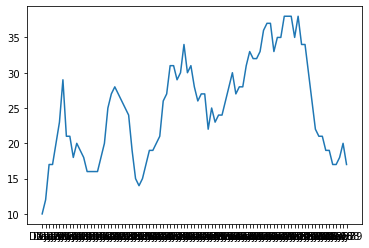

In [77]:
plt.plot(simu_counter[1].sum(axis = 0))

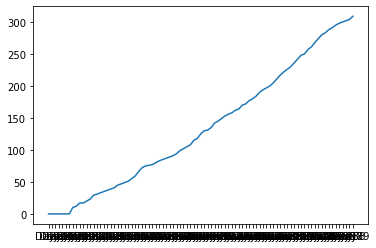

In [78]:
plt.plot(simu_counter[2].sum(axis = 0))